# ERG3020 Project

In [1]:
# IMPORTING ALL THE NECESSARY LIBRARIES AND PACKAGES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
import re
%matplotlib inline
sns.set()

In [2]:
# LOAD and set sentiment columns
def sentiment(stars):
    if stars == 5:
        return 1 #"Positive"
    elif stars == 4:
        return 0 #"Neutral"
    else:
        return -1 #"Negative"
    
data = pd.read_csv('./yelp.csv')
data['sentiment'] = data['stars'].apply(sentiment)
data = data[['user_id', 'date', 'text', 'cool', 'useful', 'funny', 'sentiment']]
print(data.shape)
data.head()

(10000, 7)


,user_id,date,text,cool,useful,funny,sentiment
0,rLtl8ZkDX5vH5nAx9C3q5Q,2011-01-26,My wife took me here on my birthday for breakf...,2,5,0,1
1,0a2KyEL0d3Yb1V6aivbIuQ,2011-07-27,I have no idea why some people give bad review...,0,0,0,1
2,0hT2KtfLiobPvh6cDC8JQg,2012-06-14,love the gyro plate. Rice is so good and I als...,0,1,0,0
3,uZetl9T0NcROGOyFfughhg,2010-05-27,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,1
4,vYmM4KTsC8ZfQBg-j5MWkw,2012-01-05,General Manager Scott Petello is a good egg!!!...,0,0,0,1


In [3]:
counts = data['sentiment'].value_counts() #neutral 3526
counts

 0    3526
 1    3337
-1    3137
Name: sentiment, dtype: int64

In [4]:
# Let tot_words = number of total words for a reviewer.
# Let avg_words = average number of words in a sentence for a reviewer.
# Investigate their relationship with review's stars.

regex_tot_words = re.compile("(?x) (?: [\w-]+ | [\x80-\xff]{3} )")
regex_tot_sentence = re.compile('|'.join(["\!\!\!\!", "\!\!\!", "\!\!", "\!", "\:\)", "\.\.\.\.", "\.\.\.", "\.\.", "\.", "\;", "\?"]))

def count_tot_words(line):
    tot_words = len(regex_tot_words.split(line))
    return max(1, tot_words)

def count_tot_sentence(line):
    tot_sentence = len(regex_tot_sentence.findall(line))
    return max(1, tot_sentence)

data['tot_words'] = data['text'].apply(count_tot_words)
data['avg_words'] = data['tot_words'] / data['text'].apply(count_tot_sentence)
data['avg_words'] = data['avg_words'].astype(np.int64)
data.head()

,user_id,date,text,cool,useful,funny,sentiment,tot_words,avg_words
0,rLtl8ZkDX5vH5nAx9C3q5Q,2011-01-26,My wife took me here on my birthday for breakf...,2,5,0,1,160,13
1,0a2KyEL0d3Yb1V6aivbIuQ,2011-07-27,I have no idea why some people give bad review...,0,0,0,1,266,14
2,0hT2KtfLiobPvh6cDC8JQg,2012-06-14,love the gyro plate. Rice is so good and I als...,0,1,0,0,16,8
3,uZetl9T0NcROGOyFfughhg,2010-05-27,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",1,2,0,1,78,13
4,vYmM4KTsC8ZfQBg-j5MWkw,2012-01-05,General Manager Scott Petello is a good egg!!!...,0,0,0,1,89,8


           tot_words  sentiment
tot_words   1.000000  -0.121657
sentiment  -0.121657   1.000000


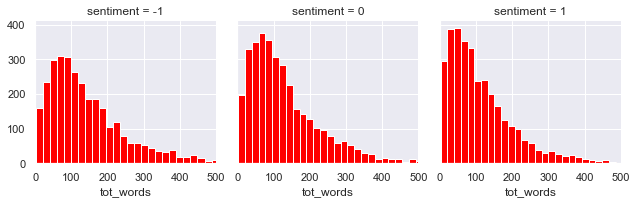

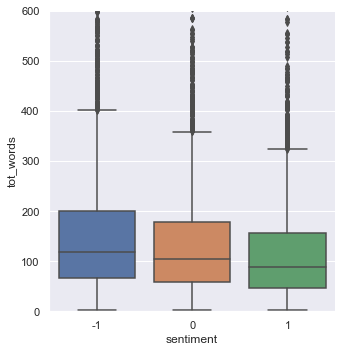

In [5]:
# Draw relationship with sentiments.
print(data[['tot_words', 'sentiment']].corr())
graph = sns.FacetGrid(data=data,col='sentiment')
graph.map(plt.hist,'tot_words',bins=50,color='red')
graph.set(xlim = (0,500))
g = sns.catplot(kind="box", x="sentiment", y="tot_words", data=data)
g.set(ylim=(0,600))
# No Strong Correlation.

           avg_words  sentiment
avg_words   1.000000  -0.057706
sentiment  -0.057706   1.000000


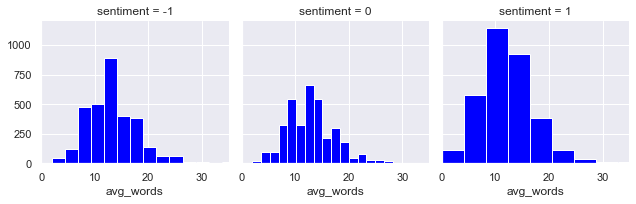

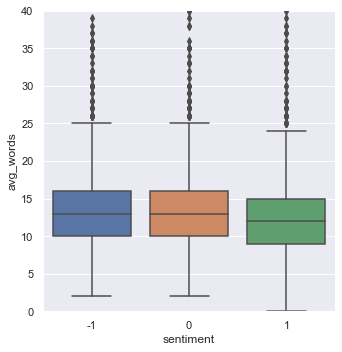

In [6]:
# Draw relationship with sentiments.
print(data[['avg_words', 'sentiment']].corr())
graph = sns.FacetGrid(data=data,col='sentiment')
graph.map(plt.hist,'avg_words',bins=50,color='blue')
graph.set(xlim = (0,35))
g = sns.catplot(kind="box", x="sentiment", y="avg_words", data=data)
g.set(ylim=(0,40))
# No Strong Correlation.

In [7]:
# Relationship between sentiment and other columns
stval = data.groupby('sentiment').mean()
stval

,cool,useful,funny,tot_words,avg_words
sentiment,,,,,
-1,0.717565,1.453618,0.834555,153.197004,13.520880
0,0.954623,1.395916,0.670448,135.227170,13.145207
1,0.944261,1.381780,0.608631,118.012886,12.643692


In [8]:
stval.corr()

,cool,useful,funny,tot_words,avg_words
cool,1.000000,-0.974686,-0.953366,-0.852587,-0.799150
useful,-0.974686,1.000000,0.996712,0.947844,0.913320
funny,-0.953366,0.996712,1.000000,0.970553,0.943314
tot_words,-0.852587,0.947844,0.970553,1.000000,0.995487
avg_words,-0.799150,0.913320,0.943314,0.995487,1.000000


## Pre Processing:
## For now, because of simplicity and time/space complexity, we define the data as:
## X[i, j]: For i text, j word appears or not, {0, 1}.
## i.e. x_train[322, 19648]=1: For the 322th text, word 'frantically' appears.
## Because the reviews with neutral sentiment are not our concern, so we ignore them for now.
## y is the sentiment of the text, negative/positive, {0, 1}

In [9]:
def set_up_data(data, ignore_Neutral_reviews=False, use_CountVectorizer=True):
    # Clean stopwords and punctuations like . , ; ! ?
    def clean_process(text):
        nopunc = [char for char in text if char not in string.punctuation]
        nopunc = ''.join(nopunc)
        return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

    if ignore_Neutral_reviews:
        temp = data[data['sentiment']!=0].copy()
    else:
        temp = data.copy()

    # Get X and Y
    x = temp['text']
    y = temp['sentiment']

    # Get vocabulary
    if use_CountVectorizer:
        vocab = CountVectorizer(analyzer=clean_process).fit(x)
    else:
        vocab = TfidfVectorizer(analyzer=clean_process).fit(x)
    print('length of the vocabulary is', len(vocab.vocabulary_))

    # Transform text to vectors
    x = vocab.transform(x)
    
    return vocab, x, y

In [10]:
def get_trainable_data(x, y):
    #Shape of the matrix:
    print("Shape of the sparse matrix: ", x.shape)
    #Non-zero occurences:
    print("Non-Zero occurences: ",x.nnz)
    # DENSITY OF THE MATRIX
    density = (x.nnz/(x.shape[0]*x.shape[1]))*100
    print("Density of the matrix = ",density)

    # SPLITTING THE DATASET INTO TRAINING SET AND TESTING SET
    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=101)
    return x_train.todense().getA(),x_test.todense().getA(),y_train.values,y_test.values

In [11]:
vocab, x, y = set_up_data(data, ignore_Neutral_reviews=True, use_CountVectorizer=True)
x_train,x_test,y_train,y_test = get_trainable_data(x, y)

length of the vocabulary is 34591
Shape of the sparse matrix:  (6474, 34591)
Non-Zero occurences:  374430
Density of the matrix =  0.16719944269174464


In [12]:
x_train[x_train>0] = 1
x_test[x_test>0] = 1
y_train[y_train==-1] = 0
y_test[y_test==-1] = 0

In [13]:
print(x_train[322, 19648])
print(vocab.get_feature_names()[19648])

1
frantically


## Then, We Implement NaiveBayes from scratch.

In [14]:
from math import pi
sqrt_2pi = (2 * pi) ** 0.5

class NaiveBayes:
    def __init__(self):
        self.prior = None
        self.mu = None
        self.sigma = None
        pass

    def MLE(self, X, y):
        # prior P,  ie. array([0.56, 0.44])
        prior_N = np.bincount(y)
        self.prior = prior_N / y.shape[0]

        # conditional P        
        self.mu = [[] for _ in range(2)]
        for K in range(2):
            self.mu[K] = np.sum(X[y==K, :], axis=0) / prior_N[K] # (57,)
            self.mu[K] += 1e-7
       
    def predict(self, X):
        _pred_y = [[] for _ in range(2)]
        for K in range(2):
            Mu = self.mu[K]
            InMu = np.log(Mu)
            InMu_supp = np.log(1-Mu)
            _pred_y[K] = np.log(self.prior[K]) + X.dot(InMu)+(1-X).dot(InMu_supp)
        pred_y = (_pred_y[1] >= _pred_y[0]).astype(np.int)
        return pred_y

In [15]:
model = NaiveBayes()
model.MLE(x_train, y_train)
predmnb = model.predict(x_test)
print("Confusion Matrix for Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:\n",classification_report(y_test,predmnb))

Confusion Matrix for Naive Bayes:
[[414 190]
 [169 522]]
Score: 72.28
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70       604
           1       0.73      0.76      0.74       691

    accuracy                           0.72      1295
   macro avg       0.72      0.72      0.72      1295
weighted avg       0.72      0.72      0.72      1295



## Our Improvements on Naive Bayes

### Remove features related to Neutral reviews!

In [16]:
Mu0, Mu1 = model.mu[0], model.mu[1]
np.sum(Mu0+Mu1== 2e-7)

4199

### Features that are similar between class 0 and 1 can also be removed

In [17]:
abs(Mu0-Mu1).mean()

0.0009831020016692054

In [59]:
feat = (model.mu[0]+model.mu[1]<=3e-7) | (abs(model.mu[0]-model.mu[1])<=0.000983)
feat = ~feat
np.sum(feat)

5116

### Selected Feature Weight

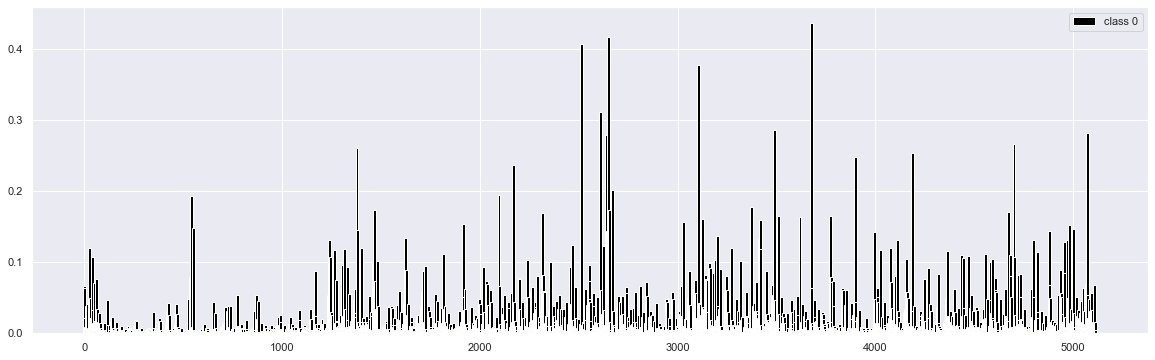

In [65]:
_=np.arange(np.sum(feat))
plt.figure(figsize=(20,6))
plt.bar(_,model.mu[0][feat],15,color='black',label='class 0')
plt.legend()
plt.show()

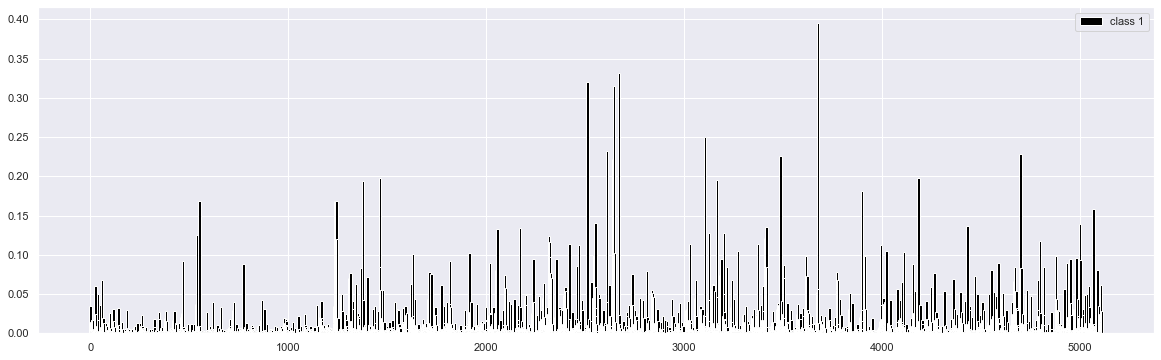

In [66]:
_=np.arange(np.sum(feat))
plt.figure(figsize=(20,6))
plt.bar(_,model.mu[1][feat],12,color='black',label='class 1')
plt.legend()
plt.show()

### New model with feature selection, improved a little bit.

In [19]:
new_model = NaiveBayes()
new_model.MLE(x_train[:,feat], y_train)
predmnb = new_model.predict(x_test[:,feat])
print("Confusion Matrix for Naive Bayes:")
print(confusion_matrix(y_test,predmnb))
print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
print("Classification Report:\n",classification_report(y_test,predmnb))

Confusion Matrix for Naive Bayes:
[[395 209]
 [143 548]]
Score: 72.82
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69       604
           1       0.72      0.79      0.76       691

    accuracy                           0.73      1295
   macro avg       0.73      0.72      0.72      1295
weighted avg       0.73      0.73      0.73      1295



## Other ML algorithms from sklearn

In [20]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def my_MultinomialNB(x_train,x_test,y_train,y_test):
    model = MultinomialNB()
    model.fit(x_train, y_train)
    predmnb = model.predict(x_test)
    print("Confusion Matrix for Multinomial Naive Bayes:")
    print(confusion_matrix(y_test,predmnb))
    print("Score:",round(accuracy_score(y_test,predmnb)*100,2))
    print("Classification Report:\n",classification_report(y_test,predmnb))
    return model

def my_MLPClassifier(x_train,x_test,y_train,y_test):
    # MULTILAYER PERCEPTRON CLASSIFIER
    mlp = MLPClassifier()
    mlp.fit(x_train,y_train)
    predmlp = mlp.predict(x_test)
    print("Confusion Matrix for Multilayer Perceptron Classifier:")
    print(confusion_matrix(y_test,predmlp))
    print("Score:",round(accuracy_score(y_test,predmlp)*100,2))
    print("Classification Report:")
    print(classification_report(y_test,predmlp))
    return mlp

def my_KNeighborsClassifier(x_train,x_test,y_train,y_test):
    # KNN
    knn = KNeighborsClassifier(n_neighbors=10)
    knn.fit(x_train,y_train)
    predknn = knn.predict(x_test)
    print("Confusion Matrix for K Neighbors Classifier:")
    print(confusion_matrix(y_test,predknn))
    print("Score: ",round(accuracy_score(y_test,predknn)*100,2))
    print("Classification Report:")
    print(classification_report(y_test,predknn))
    return knn

def my_RandomForest(x_train,x_test,y_train,y_test):
    # Random Forest
    rmfr = RandomForestClassifier()
    rmfr.fit(x_train,y_train)
    predrmfr = rmfr.predict(x_test)
    print("Confusion Matrix for Random Forest Classifier:")
    print(confusion_matrix(y_test,predrmfr))
    print("Score:",round(accuracy_score(y_test,predrmfr)*100,2))
    print("Classification Report:\n",classification_report(y_test,predrmfr))
    return rmfr

def my_SVM(x_train,x_test,y_train,y_test):
    # Support vector machine
    svm = SVC(random_state=101)
    svm.fit(x_train,y_train)
    predsvm = svm.predict(x_test)
    print("Confusion Matrix for Support Vector Machines:")
    print(confusion_matrix(y_test,predsvm))
    print("Score:",round(accuracy_score(y_test,predsvm)*100,2))
    print("Classification Report:\n", classification_report(y_test,predsvm))
    return svm

## Also,
## We use Naive Bayes to train and test (Because it is robust),
## To Set up the configuration of the Neutral reviews and Vectorizer, 

In [12]:
vocab, x, y = set_up_data(data, ignore_Neutral_reviews=False, use_CountVectorizer=True)
x_train,x_test,y_train,y_test = get_trainable_data(x, y)
model = my_MultinomialNB(x_train,x_test,y_train,y_test)

length of the vocabulary is 44012
Shape of the sparse matrix:  (10000, 44012)
Non-Zero occurences:  583230
Density of the matrix =  0.1325161319640098
Confusion Matrix for Multinomial Naive Bayes:
[[429 157  40]
 [ 99 485 129]
 [ 57 259 345]]
Score: 62.95
Classification Report:               precision    recall  f1-score   support

          -1       0.73      0.69      0.71       626
           0       0.54      0.68      0.60       713
           1       0.67      0.52      0.59       661

    accuracy                           0.63      2000
   macro avg       0.65      0.63      0.63      2000
weighted avg       0.64      0.63      0.63      2000



In [17]:
vocab, x, y = set_up_data(data, ignore_Neutral_reviews=False, use_CountVectorizer=False)
x_train,x_test,y_train,y_test = get_trainable_data(x, y)
model = my_MultinomialNB(x_train,x_test,y_train,y_test)

length of the vocabulary is 44012
Shape of the sparse matrix:  (10000, 44012)
Non-Zero occurences:  583230
Density of the matrix =  0.1325161319640098
Confusion Matrix for Multinomial Naive Bayes:
[[352 258  16]
 [ 54 595  64]
 [ 31 417 213]]
Score: 58.0
Classification Report:               precision    recall  f1-score   support

          -1       0.81      0.56      0.66       626
           0       0.47      0.83      0.60       713
           1       0.73      0.32      0.45       661

    accuracy                           0.58      2000
   macro avg       0.67      0.57      0.57      2000
weighted avg       0.66      0.58      0.57      2000



In [18]:
vocab, x, y = set_up_data(data, ignore_Neutral_reviews=True, use_CountVectorizer=False)
x_train,x_test,y_train,y_test = get_trainable_data(x, y)
model = my_MultinomialNB(x_train,x_test,y_train,y_test)

length of the vocabulary is 34591
Shape of the sparse matrix:  (6474, 34591)
Non-Zero occurences:  374430
Density of the matrix =  0.16719944269174464
Confusion Matrix for Multinomial Naive Bayes:
[[534  70]
 [134 557]]
Score: 84.25
Classification Report:               precision    recall  f1-score   support

          -1       0.80      0.88      0.84       604
           1       0.89      0.81      0.85       691

    accuracy                           0.84      1295
   macro avg       0.84      0.85      0.84      1295
weighted avg       0.85      0.84      0.84      1295



### Best Model Setting

In [12]:
vocab, x, y = set_up_data(data, ignore_Neutral_reviews=True, use_CountVectorizer=True)
x_train,x_test,y_train,y_test = get_trainable_data(x, y)
best_model = my_MultinomialNB(x_train,x_test,y_train,y_test)

length of the vocabulary is 34591
Shape of the sparse matrix:  (6474, 34591)
Non-Zero occurences:  374430
Density of the matrix =  0.16719944269174464
Confusion Matrix for Multinomial Naive Bayes:
[[515  89]
 [ 99 592]]
Score: 85.48
Classification Report:
               precision    recall  f1-score   support

          -1       0.84      0.85      0.85       604
           1       0.87      0.86      0.86       691

    accuracy                           0.85      1295
   macro avg       0.85      0.85      0.85      1295
weighted avg       0.86      0.85      0.85      1295



### Naive Bayes, KNN, MLP, RandomForest, SVM
### To make the experiements fair, all from sklearn package

In [58]:
Naive_Bayes_model = my_MultinomialNB(x_train,x_test,y_train,y_test)
print("----------------------------------------------------")
KNN_model = my_KNeighborsClassifier(x_train,x_test,y_train,y_test)
print("----------------------------------------------------")
MLP_model = my_MLPClassifier(x_train,x_test,y_train,y_test)
print("----------------------------------------------------")
RF_model = my_RandomForest(x_train,x_test,y_train,y_test)
print("----------------------------------------------------")
SVM_model = my_SVM(x_train,x_test,y_train,y_test)
print("----------------------------------------------------")

Confusion Matrix for Multinomial Naive Bayes:
[[515  89]
 [ 99 592]]
Score: 85.48
Classification Report:
               precision    recall  f1-score   support

          -1       0.84      0.85      0.85       604
           1       0.87      0.86      0.86       691

    accuracy                           0.85      1295
   macro avg       0.85      0.85      0.85      1295
weighted avg       0.86      0.85      0.85      1295

----------------------------------------------------
Confusion Matrix for K Neighbors Classifier:
[[315 289]
 [161 530]]
Score:  65.25
Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.52      0.58       604
           1       0.65      0.77      0.70       691

    accuracy                           0.65      1295
   macro avg       0.65      0.64      0.64      1295
weighted avg       0.65      0.65      0.65      1295

----------------------------------------------------
Confusion Matrix for Multilay

## Show some prediction results

In [77]:
# randomly test 5 texts.
def random_test(size,data,model):
    np.random.seed(1)
    random_number = np.random.choice(len(data['text']),size = size)
    stmt_test = data['sentiment'][random_number]
    prd_stmt_a = np.empty(shape = [size,0])
    for i in random_number:
        txt_test = data['text'][i]
        
        print(txt_test)
        print("Actual Sentiment: ",data['sentiment'][i])
        txt_test_t = vocab.transform([txt_test])
        prd_stmt = model.predict(txt_test_t)[0] #predicted value
        print("Predicted Sentiment:", prd_stmt)
        prd_stmt_a = np.append(prd_stmt_a, prd_stmt)
        print("------------------------------------------------------------------------")
    score = ((stmt_test==prd_stmt_a).mean())
    print('Overal Accuracy: ', score)
random_test(5,data,Naive_Bayes_model)

I used to frequent the Lost Leaf almost daily starting the day they opened, unfortunately I cannot say the same anymore. I used to love the refrigerator full of beers, the music, and the cool little home, not to mention the biggest thing, the promise of a full bar. Now, everytime I go there it's full of douchebags, they are out of the beer I want, and the music has somehow become sucky. Perhaps the biggest kicker... there is still no full bar! The servers are surly kids, who have the audacity to tell you were you cannot stand, seemingly forgetting they work in the hospitality industry. If this were a city with a ton of good bars, that would never fly. But since they are one of the only games in the area, most people go back just out of convienence. The last time I was there, we coaxed a bum to dance to 1920's tunes that were being played out of the treehouse out front. That was about the only redeeming quality. And I swear if I see one more dude with girls jeans trying to look cool wit